In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import os
import glob
import sys
from datetime import date
import json
import pandas as pd
import pickle

import neuraltoolkit as ntk
from samb_work import dimtools as dimt

from scipy.io import savemat, loadmat
from scipy.stats import mode
from scipy.stats import ranksums

from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})

today = date.today()
today = today.strftime("%Y_%m_%d")

basedir = '/hlabhome/sbrunwa/git/appps1'
pth = f'{basedir}/notebooks/figure_4/'

In [2]:
#--------------------- Colors ---------------------

with open(f'{basedir}/colormaps/geno_colors.json') as json_file:
    geno_clrs = json.load(json_file)

dump = 0

In [3]:
def curve_function(x, a, b, c):
    return a * np.exp(-b * x) + c

def calc_dim_from_curve(curvedat,maxval,target=0.95):
    #how many dimensions needed to reach 95% max regression performance

    components = np.arange(curvedat.shape[0])
    y = curvedat/maxval
        
    try:
        ev_cumfits, pcov = curve_fit(curve_function, components, y)
        
        if (np.sum(np.isinf(pcov)) > 0):
            dim95 = np.nan
        else:
            a_term = ev_cumfits[0]
            b_term = ev_cumfits[1]
            c_term = ev_cumfits[2]

            #derived from y = ae^(-bx)+c to solve for x
            dim95 = (-1)*(np.log((target-c_term)/a_term))/b_term

            #have to add 1 because we start with 0 index (technically 0th x position is 1 dimension)
            dim95 += 1

    except:
        dim95 = np.nan
        pcov = np.nan
    
    return(dim95)

In [4]:
epochs = ('CAF69_1228_0-12',
'CAF69_1230_0-12',
'CAF69_1230_12-24',
'CAF71_0103_0-12',
'CAF71_0103_12-20',
'CAF73_0120_4-15',
'CAF73_0120_15-24',
'CAF74_0125_48-60',
'CAF74_0125_60-72',
'CAF75_0125_53-64',
'CAF75_0125_65-76',
'CAF77_0202_12-24',
'CAF81_0304_0-12',
'CAF81_0304_12-24',
'CAF82_0304_0-12',
'CAF82_0304_12-24')

rrrdir = f'{basedir}/data/rrr/'
wt = ['CAF69','CAF77','CAF81','CAF82']
app = ['CAF71','CAF73','CAF74','CAF75']
colors = {'wt': 'blue', 'app': 'red'}

comps = ['rsc_v1','rsc_acc']

<h1>Panel A: Comm Subspace Curves by Genotype</h1>

/hlabhome/sbrunwa/.conda/envs/appps1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/hlabhome/sbrunwa/.conda/envs/appps1/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/hlabhome/sbrunwa/.conda/envs/appps1/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/hlabhome/sbrunwa/.conda/envs/appps1/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/hlabhome/sbrunwa/.conda/envs/appps1/lib/python3.10/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


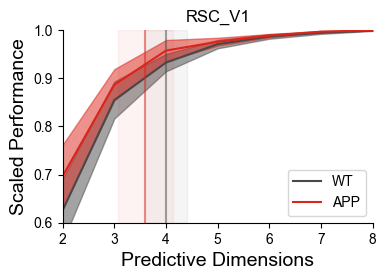

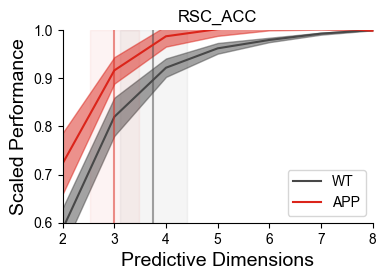

In [5]:
comparrays = []
dump = 1
for comp in comps:

    epochlist_wt = []
    epochlist_app = []
    animallist_wt = []
    animallist_app = []
    animallist = []

    y_s_wt = np.full((len(epochs),10),np.nan)
    y_s_app = np.full((len(epochs),10),np.nan)
    optdim_wt = np.full(len(epochs),np.nan)
    optdim_app = np.full(len(epochs),np.nan)

    for j, ep in enumerate(epochs):

        rrrfiles = np.sort(glob.glob(rrrdir + ep + '_*' + comp + '_*_rrr.mat'))
        
        animal = ep.split('_')[0]
        animallist.append(animal)
        if animal in wt:
            geno='wt'
        elif animal in app:
            geno='app'

        color = plt.cm.rainbow(np.linspace(0, 1, len(epochs)))
        Y_all = np.zeros([len(rrrfiles),10])
        e_all = np.zeros([len(rrrfiles),10])
        optdim_all = np.zeros(len(rrrfiles))

        for f,fil in enumerate(rrrfiles):
            plottitle = fil.split('/')[-1].strip('_rrr.mat')
            dat = loadmat(fil)
            X = dat['x'][0]
            Y_all[f,:] = dat['y'][0]
            e_all[f,:] = dat['e'][0]
            optdim_all[f] = dat['optDimReducedRankRegress']

        Y = np.mean(Y_all,axis=0)
        e = np.std(Y_all,axis=0) 
        optdim_x = optdim_all
        optdim = mode(optdim_all)[0]

        #only include if model actually improved
        #check by determining if final performance is better than
        # crossval error on performance at 1 dimension
        perf_improved = Y[-1] > Y[0] + e[0]
        perf_nonneg = Y[-1] > 0

        if perf_improved & perf_nonneg:

            maxy = np.mean(Y[6:])
            miny = Y[0]
            Y_scaled = (1-0)/(maxy-miny)*(Y-maxy)+1 #0-1 scaling

            if geno == 'wt':
                y_s_wt[j,:] = Y_scaled
                optdim_wt[j] = optdim
                epochlist_wt.append(ep)
                animallist_wt.append(animal)

            elif geno == 'app':
                y_s_app[j,:] = Y_scaled
                optdim_app[j] = optdim
                epochlist_app.append(ep)
                animallist_app.append(animal)

    n_epoch_wt = len(np.unique(epochlist_wt))
    n_epoch_app = len(np.unique(epochlist_app))

    fig, ax = plt.subplots(figsize=(4,2.5))

    ax.plot(X[1:8], np.nanmean(y_s_wt[:,1:8],axis=0),c=geno_clrs['WT'],label='WT')
    ax.fill_between(X[1:8],
        np.nanmean(y_s_wt[:,1:8],axis=0) - np.nanstd(y_s_wt[:,1:8],axis=0)/np.sqrt(n_epoch_wt),
        np.nanmean(y_s_wt[:,1:8],axis=0) + np.nanstd(y_s_wt[:,1:8],axis=0)/np.sqrt(n_epoch_wt),
        color = geno_clrs['WT'], alpha = 0.5)
    ax.axvline(np.nanmean(optdim_wt),alpha=0.5,c=geno_clrs['WT'])
    ax.axvspan(np.nanmean(optdim_wt) - np.nanstd(optdim_wt)/np.sqrt(4),
        np.nanmean(optdim_wt) + np.nanstd(optdim_wt)/np.sqrt(4),
        alpha=0.05, color=geno_clrs['WT'])

    ax.plot(X[1:8], np.nanmean(y_s_app[:,1:8],axis=0),c=geno_clrs['APP'],label='APP')
    ax.fill_between(X[1:8],
        np.nanmean(y_s_app[:,1:8],axis=0) - np.nanstd(y_s_app[:,1:8],axis=0)/np.sqrt(n_epoch_app),
        np.nanmean(y_s_app[:,1:8],axis=0) + np.nanstd(y_s_app[:,1:8],axis=0)/np.sqrt(n_epoch_app),
        color = geno_clrs['APP'], alpha = 0.5)
    ax.axvline(np.nanmean(optdim_app),alpha=0.5,c=geno_clrs['APP'])
    ax.axvspan(np.nanmean(optdim_app) - np.nanstd(optdim_app)/np.sqrt(n_epoch_app),
        np.nanmean(optdim_app) + np.nanstd(optdim_app)/np.sqrt(n_epoch_app),
        alpha=0.05, color=geno_clrs['APP'])

    ax.legend(loc='lower right')
    ax.set_ylabel('Scaled Performance',fontsize=14)
    ax.set_xlabel('Predictive Dimensions',fontsize=14)
    ax.set_title(f'{comp.upper()}')
    ax.set_xlim(2,8)
    ax.set_ylim(0.6,1)
    sns.despine()

    epocharray = np.array(epochs)
    animalarray = np.array(animallist)
    circuitarray = np.tile(comp,len(epochs))
    optdimarray = optdim_wt.copy()
    optdimarray[np.isnan(optdim_wt)] = optdim_app[np.isnan(optdim_wt)]
    comparrays.append(
        pd.DataFrame({'epoch': epocharray,
            'animal': animalarray,
            'circuit': circuitarray,
            'optdim': optdimarray})
        )
    
    if dump:
        filename = f'commsub_curve_{comp}.pdf'
        plt.savefig(pth+today+filename)
    else:
        pass
    
    plt.show()

<h1>Panel B: Interaction Dimensionality Boxplot </h1>

In [6]:
comparrays = []
for comp in comps:
    
    filelist = []
    animallist = []
    genolist = []
    perfimp = []
    perfnonneg = []
    optdimlist = []
    
    rrrfiles = np.sort(glob.glob(rrrdir + '*' + comp + '_*_rrr.mat'))

    for f,fil in enumerate(rrrfiles):
        
        filelist.append(fil)
        animal = fil.split('/')[-1].split('_')[0]
        animallist.append(animal)
        if animal in wt:
            geno='wt'
        elif animal in app:
            geno='app'
            
        genolist.append(geno)
            
        dat = loadmat(fil)
        X = dat['x'][0]
        Y = dat['y'][0]
        e = dat['e'][0]
        optdim = dat['optDimReducedRankRegress']

        #only include if model actually improved
        #check by determining if final performance is better than
        # crossval error on performance at 1 dimension
        perf_improved = Y[-1] > Y[0] + e[0]
        perf_nonneg = Y[-1] > 0
        
        perfimp.append(perf_improved)
        perfnonneg.append(perf_nonneg)

        maxy = np.mean(Y[6:])
        miny = Y[0]
        Y_scaled = (1-0)/(maxy-miny)*(Y-maxy)+1 #0-1 scaling
        intdim95 = calc_dim_from_curve(Y_scaled,0.95)
        
        optdimlist.append(intdim95)

    animalarray = np.array(animallist)
    circuitarray = np.tile(comp,len(rrrfiles))
    optdimarray = np.array(optdimlist)
    
    comparrays.append(
        pd.DataFrame({'animal': animalarray,
            'circuit': circuitarray,
            'genotype': genolist,
            'optdim': optdimarray,
            'perf_improved': perfimp,
            'perf_nonneg': perfnonneg,
            'file':filelist})
        )

intdf = pd.concat(comparrays)
intdf = intdf[(intdf.perf_improved == True) & (intdf.perf_nonneg == True)]
intdf = intdf.dropna()

/hlabhome/sbrunwa/.conda/envs/appps1/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_103905/3680059918.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  Y_scaled = (1-0)/(maxy-miny)*(Y-maxy)+1 #0-1 scaling
/tmp/ipykernel_103905/3680059918.py:43: RuntimeWarning: invalid value encountered in multiply
  Y_scaled = (1-0)/(maxy-miny)*(Y-maxy)+1 #0-1 scaling
/tmp/ipykernel_103905/3604277954.py:50: RuntimeWarning: invalid value encountered in log
  dim95 = (-1)*(np.log((target-c_term)/a_term))/b_term


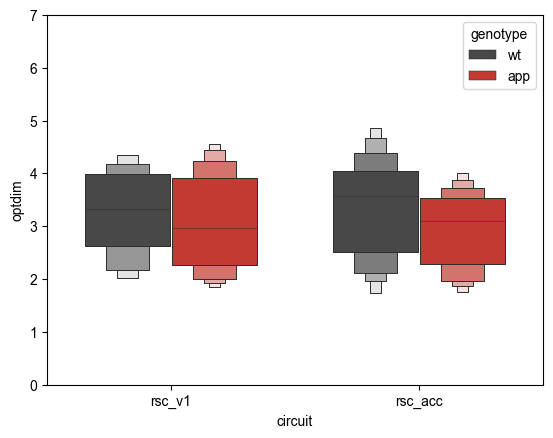

In [7]:
sns.boxenplot(x = 'circuit', y = 'optdim', hue ='genotype', data = intdf.dropna(),
    palette = [geno_clrs['WT'],geno_clrs['APP']], linewidth = 0.7, width = 0.7, dodge = True, showfliers = False)

# sns.stripplot(x = 'circuit', y = 'optdim', hue ='genotype', data = intdf.dropna(),
#     palette = ['black','black'], alpha=0.6, dodge=True)

plt.ylim(0,7)

if dump:
    filename = f'intdim_boxplot.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass

plt.show()

In [9]:
ranksums(intdf[(intdf.circuit=='rsc_v1')&(intdf.genotype=='wt')].optdim,
         intdf[(intdf.circuit=='rsc_v1')&(intdf.genotype=='app')].optdim)

RanksumsResult(statistic=1.5454778014233956, pvalue=0.12223073429039352)

In [10]:
ranksums(intdf[(intdf.circuit=='rsc_acc')&(intdf.genotype=='wt')].optdim,
         intdf[(intdf.circuit=='rsc_acc')&(intdf.genotype=='app')].optdim)

RanksumsResult(statistic=4.006455819544874, pvalue=6.163664794495224e-05)

In [11]:
ranksums(intdf[(intdf.circuit=='rsc_v1')&(intdf.genotype=='app')].optdim,
         intdf[(intdf.circuit=='rsc_acc')&(intdf.genotype=='app')].optdim)

RanksumsResult(statistic=1.484192210356743, pvalue=0.13775793574740822)

<h1>Panel C: Interaction Dimensionality Histograms </h1>

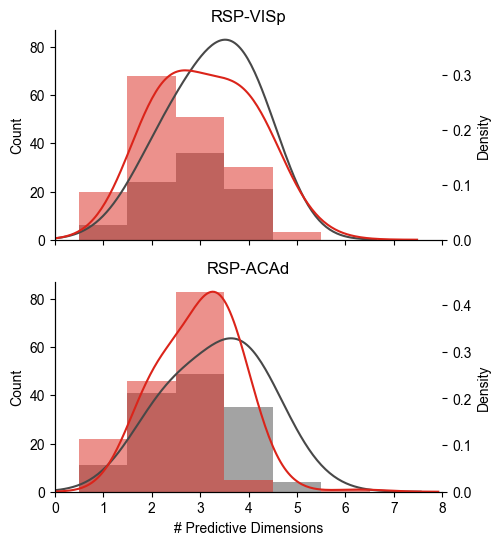

In [13]:
vals_wt_acc, edges_wt_acc = np.histogram(intdf[(intdf.genotype=='wt')&(intdf.circuit=='rsc_acc')].optdim,
    bins=np.arange(10))#,density=True)
vals_app_acc, edges_app_acc = np.histogram(intdf[(intdf.genotype=='app')&(intdf.circuit=='rsc_acc')].optdim,
    bins=np.arange(10))#,density=True)
vals_wt_v1, edges_wt_v1 = np.histogram(intdf[(intdf.genotype=='wt')&(intdf.circuit=='rsc_v1')].optdim,
    bins=np.arange(10))#,density=True)
vals_app_v1, edges_app_v1 = np.histogram(intdf[(intdf.genotype=='app')&(intdf.circuit=='rsc_v1')].optdim,
    bins=np.arange(10))#,density=True)

# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5),sharey = True)
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (5,6),sharex = True, sharey=True)

ax[0].bar(edges_wt_v1[:-1], vals_wt_v1, color=geno_clrs['WT'],alpha=0.5,width=1)
ax[0].bar(edges_app_v1[:-1], vals_app_v1, color=geno_clrs['APP'],alpha=0.5,width=1)

# ax[0].axvline(np.mean(intdf[(intdf.genotype=='wt')&(intdf.circuit=='rsc_v1')].optdim),color=geno_clrs['WT'],alpha=0.4, linestyle = '--')
# ax[0].axvline(np.mean(intdf[(intdf.genotype=='app')&(intdf.circuit=='rsc_v1')].optdim),color=geno_clrs['APP'],alpha=0.4, linestyle = '--')

ax[1].bar(edges_wt_acc[:-1], vals_wt_acc, color=geno_clrs['WT'],alpha=0.5,width=1)
ax[1].bar(edges_app_acc[:-1], vals_app_acc, color=geno_clrs['APP'],alpha=0.5,width=1)

# ax[1].axvline(np.mean(intdf[(intdf.genotype=='wt')&(intdf.circuit=='rsc_acc')].optdim),color=geno_clrs['WT'],alpha=0.4, linestyle = '--')
# ax[1].axvline(np.mean(intdf[(intdf.genotype=='app')&(intdf.circuit=='rsc_acc')].optdim),color=geno_clrs['APP'],alpha=0.4, linestyle = '--')

# Make KDE curves but share the x axis with another y
ax_a = ax[0].twinx() 
ax_b = ax[1].twinx() 
sns.kdeplot(ax = ax_a, data = intdf[(intdf.genotype=='wt')&(intdf.circuit=='rsc_v1')], x = 'optdim', bw_adjust=2, color = geno_clrs['WT'], common_norm = 1)
sns.kdeplot(ax = ax_a, data = intdf[(intdf.genotype=='app')&(intdf.circuit=='rsc_v1')], x = 'optdim', bw_adjust=2, color = geno_clrs['APP'], common_norm = 1)

sns.kdeplot(ax = ax_b, data = intdf[(intdf.genotype=='wt')&(intdf.circuit=='rsc_acc')], x = 'optdim', bw_adjust=2, color = geno_clrs['WT'], common_norm = 1)
sns.kdeplot(ax = ax_b, data = intdf[(intdf.genotype=='app')&(intdf.circuit=='rsc_acc')], x = 'optdim',bw_adjust=2, color = geno_clrs['APP'], common_norm = 1)


ax[0].set_xlim(0,8)
ax[0].set_title('RSP-VISp')

ax[1].set_xlim(0,8)
ax[1].set_title('RSP-ACAd')
ax[0].set_ylabel('Count')

ax[1].set_xlabel('# Predictive Dimensions')
ax[1].set_ylabel('Count')
sns.despine()

if dump:
    filename = f'intdim_histograms.pdf'
    plt.savefig(pth+today+filename)
else:
    pass

plt.show()